<a href="https://colab.research.google.com/github/mashruravi/clf-tiny-imagenet/blob/master/A4_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EIP 3.0 - Assignment 4
*Submission by Ravi Suresh Mashru*


## Abstract
This assignment required training a deep neural network to perform image classification on the Tiny ImageNet dataset. The assignment contraints were:
1. At least 5 variants of image augmentation should be performed.
1. A validation score of >45% has to be obtained.
1. The network should be trained for up to 500 epochs only.
1. The deep network should not have more than 26 million parameters.
1. 1x1 convolutions cannot be used to increase the number of channels.
1. Dropout layers cannot be used.
1. Fully connected layers cannot be used.


In my submission below,
1. I use the following variants of image augmentation:
  * Rotation
  * Horizontal Shift
  * Vertical Shift
  * Horizontal Flip
  * Vertical Flip
  
2. I obtained a validation score of **55.28%**.
3. I obtained the above score by training the network for only **60 epochs**.
4. I used a network with approximately **9.2 million parameters**, which is over 16 million parameters less than the constraint.
5. I used the **cylic learning rate** scheme to train the neural network.
6. I did not use 1x1 convolutions, dropout, or fully connected layers.

I also used the TPU environment on Google Colaboratory to train my network, which allowed me to complete one epoch in approximately **100 seconds **(compared to 700 seconds using a GPU, with the same architecture).


In [0]:
# Download the dataset
!curl http://cs231n.stanford.edu/tiny-imagenet-200.zip --output tiny-imagenet-200.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  236M  100  236M    0     0  4905k      0  0:00:49  0:00:49 --:--:-- 8000k


In [0]:
# Extract the data
!unzip -q tiny-imagenet-200.zip

In [0]:
# Load training and validation data
from keras.utils import np_utils
import numpy as np
import os
import time
from PIL import Image

start = time.time()

num_classes = 200
imgs_per_class = 500

X_train = np.zeros([num_classes * imgs_per_class, 64, 64, 3], dtype='uint8')
y_train = np.zeros([num_classes * imgs_per_class, 1], dtype='uint8')

# Create class to integer map
class_int_map = {}
class_list = []
for i, class_name in enumerate(os.listdir(os.getcwd() + '/tiny-imagenet-200/train')):
    if not class_name.startswith('.'): # Ignore the .DS_Store folder on Mac
        class_list.append(class_name)
        
for num, class_name in enumerate(class_list):
    class_int_map[class_name] = num

i=0
for class_name, class_index in class_int_map.items():
    
    for img_name in os.listdir(os.getcwd() + '/tiny-imagenet-200/train/' + class_name + '/images'):
        y_train[i] = [class_int_map[class_name]]
        
        img = Image.open(os.getcwd() + '/tiny-imagenet-200/train/'+class_name+'/images/'+img_name)
        X = np.array(img.resize((64, 64)))
        
        if(len(X.shape) == 2):
            X = np.array([X, X, X])
            X = np.transpose(X, (1, 2, 0))
        X_train[i] = X
        
        i+=1
        
end = time.time()
print('Training data loaded in {} seconds...'.format(end - start))


start = time.time()
val_imgname_class_map = {}
with open('tiny-imagenet-200/val/val_annotations.txt', 'r') as f:
    lines = f.read().split('\n')
    for line in lines:
        if line: # to skip the last blank line
            line_parts = line.split('\t')
            val_imgname_class_map[line_parts[0]] = line_parts[1]
            
val_img_names = os.listdir(os.getcwd() + '/tiny-imagenet-200/val/images/')
val_img_count = len(val_img_names)

X_val = np.zeros([val_img_count, 64, 64, 3], dtype='uint8')
y_val = np.zeros([val_img_count, 1], dtype='uint8')

i = 0
for img_name in val_img_names:
    y_val[i] = [class_int_map[val_imgname_class_map[img_name]]]
    
    img = Image.open(os.getcwd() + '/tiny-imagenet-200/val/images/'+img_name)
    X = np.array(img.resize((64, 64)))
    if(len(X.shape) == 2):
        X = np.array([X, X, X])
        X = np.transpose(X, (1, 2, 0))
    X_val[i] = X
    
    i+=1
    
end = time.time()
print('Validation data loaded in {} seconds...'.format(end - start))

y_train_onehot = np_utils.to_categorical(y_train)
y_val_onehot = np_utils.to_categorical(y_val)

Using TensorFlow backend.


Training data loaded in 27.454161882400513 seconds...
Validation data loaded in 2.777902364730835 seconds...


## Model Architecture

For this assignment, I used a modified version of the Wide Residual Network (WRN) architecture. [Zagorukyo & Komodakis](https://arxiv.org/abs/1605.07146) show that deep residual networks are very slow to train because of diminishing feature reuse. They propose the WRN architecture which modifies residual blocks that were introduced in the ResNet architecture, by increasing their width (increasing the number of filters per layer) and decreasing their depth (reducing the number of ResNet blocks).

I did not follow the exact architecture proposed in the paper. I tweaked some parts of the network based on learnings from EIP.

In particular, I increased the number of channels in the first convolution layer to ensure that the inital layers of the network are learning as many features as possible.

I also removed the fully connected layer and replaced it with a Global Average Pooling layer.

I also did not use Dropout layers, and instead used L2 regularization and image augmentation to tackle overfitting.

In [0]:
from __future__ import division

import six
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    GlobalAveragePooling2D
)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


weight_decay = 0.0005

def initial_conv(input):
    x = Conv2D(100, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv_init")(input)

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN_init")(x)
    x = Activation('relu')(x)
    return x


def expand_conv(idx, init, base, k, strides=(1, 1)):
    x = Conv2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv_expand_"+str(idx)+"_1")(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN_expand"+str(idx))(x)
    x = Activation('relu')(x)

    x = Conv2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv_expand_"+str(idx)+"_2")(x)

    skip = Conv2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv_expand_"+str(idx)+"_3")(init)

    m = add([x, skip])

    return m


def conv1_block(idx, input, k=1, dropout=0.0):
    init = input

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN1_"+str(idx)+"_1")(input)
    x = Activation('relu')(x)
    x = Conv2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv1_"+str(idx)+"_1")(x)

    if dropout > 0.0: x = Dropout(rate=dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN1_"+str(idx)+"_2")(x)
    x = Activation('relu')(x)
    x = Conv2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv1_"+str(idx)+"_2")(x)

    m = add([init, x])
    return m

def conv2_block(idx, input, k=1, dropout=0.0):
    init = input

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN2_"+str(idx)+"_1")(input)
    x = Activation('relu')(x)
    x = Conv2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv2_"+str(idx)+"_1")(x)

    if dropout > 0.0: x = Dropout(rate=dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN2_"+str(idx)+"_2")(x)
    x = Activation('relu')(x)
    x = Conv2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False,name="conv2_"+str(idx)+"_2")(x)

    m = add([init, x])
    return m

def conv3_block(idx, input, k=1, dropout=0.0):
    init = input

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN3_"+str(idx)+"_1")(input)
    x = Activation('relu')(x)
    x = Conv2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv3_"+str(idx)+"_1")(x)

    if dropout > 0.0: x = Dropout(rate=dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN3_"+str(idx)+"_2")(x)
    x = Activation('relu')(x)
    x = Conv2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv3_"+str(idx)+"_2")(x)

    m = add([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(1, x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(i, x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN_1")(x)
    x = Activation('relu')(x)

    x = expand_conv(2, x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(i, x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN_2")(x)
    x = Activation('relu')(x)

    x = expand_conv(3, x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(i, x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN_3")(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_classes, (1,1), padding="same", name="conv_final")(x)
    x = GlobalAveragePooling2D(name="GAP")(x)
    x = Activation("softmax")(x)

    model = Model(ip, x)

    if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    return model

In [0]:
import tensorflow as tf
model64 = create_wide_residual_network((64, 64, 3), nb_classes=200, N=4, k=5)

Instructions for updating:
Colocations handled automatically by placer.
Wide Residual Network-28-5 created.


In [0]:
model64.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv_init (Conv2D)              (None, 64, 64, 100)  2700        input_1[0][0]                    
__________________________________________________________________________________________________
BN_init (BatchNormalizationV1)  (None, 64, 64, 100)  400         conv_init[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 100)  0           BN_init[0][0]                    
__________________________________________________________________________________________________
conv_expan

In [0]:
import os

tpu_model64 = tf.contrib.tpu.keras_to_tpu_model(
    model64,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_model64.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.94.145.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11793125802818997041)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 222014773708665408)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 688473507330456592)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, 

In [0]:
# Image augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_datagen.fit(X_train)

## Cyclic Learning Rate

I used the cyclic learning rate scheme introduced by Leslie Smith in the paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). In this scheme, the learning rate is continuously varied between two values during training instead of keeping it fixed.

To get the two values between which the learning rate should be varied, a Learning Rate range test is performed. In this test, the learning rate is increased from an extremely low value to an extremely high value. The learning rate is updated for every batch sent to the neural network. The loss values of the network are then plotted against the learning rate on a graph. The learning rate on the graph _after the section_* where the reduction in loss is the steepest is kept as the upper bound of the cylic learning rate scheme. The lower bound is taken to be about 1/10 of this value.

`*` In the paper, Leslie Smith recommends using the learning rate where the change in loss is the steepest as the upper bound of the cyclic learning rate scheme. However, in the [fast.ai lessons](https://course.fast.ai/), Jeremy Howard shows that it is actually better to use a learning rate that is slightly higher than that value as the upper bound.

In [0]:
from tensorflow.keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
clr = CyclicLR(base_lr=0.00001, max_lr=1.5, step_size=5000)

In [0]:
BATCH_SIZE=1024
history_init = tpu_model64.fit(
    X_train, y_train_onehot, batch_size=BATCH_SIZE,
    epochs=50,
    callbacks=[clr]
)

Epoch 1/50
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 64, 64, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(128, 200), dtype=tf.float32, name='activation_25_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning SGD {'lr': 9.999999747378752e-06, 'momentum': 0.0, 'decay': 0.0, 'nesterov': False}
INFO:tensorflow:Remapping placeholder for input_1
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.SGD object at 0x7fafb40d98d0> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 30.648479223251343 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 9.999999747378752e-06 {1e-05}
INFO:tensorflow:CPU -> TPU momentum: 0.0 {0.0}
INFO:tensorflow:CPU -> TPU decay:

LR range vs iteration


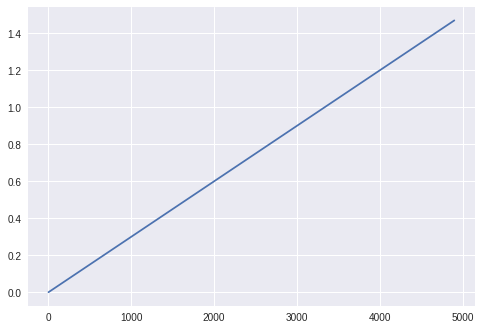

Loss vs LR


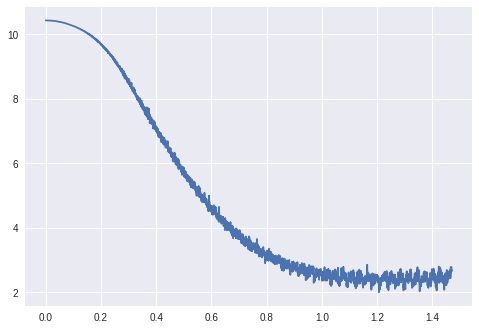

In [0]:
lr = clr.history['lr']
loss = clr.history['loss']

import matplotlib.pyplot as plt
print('LR range vs iteration')
plt.plot(range(len(lr)), lr)
plt.show()
print('Loss vs LR')
plt.plot(lr, loss)
plt.show()

From the above graph, the loss is reducing fastest when the learning rate is around 0.6. Therefore, as described above, we take the upper bound of the cyclic learning rate scheme as **0.8** and the lower bound as 1/10 of this value, i.e. **0.08**.

In [0]:
import os

model = create_wide_residual_network((64, 64, 3), nb_classes=200, N=4, k=5)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

clr = CyclicLR(base_lr=0.08, max_lr=0.8, step_size=980)
# Step size = 980 => 20 epochs = 1 cycle, 10 epochs = 1 step size

Wide Residual Network-28-5 created.
INFO:tensorflow:Querying Tensorflow master (grpc://10.94.145.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11793125802818997041)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 222014773708665408)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 688473507330456592)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2562041439673439253)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 6290636814627968912)
INFO:tensorflow:*** Ava

In [0]:
BATCH_SIZE=1024
history1 = tpu_model.fit_generator(
    train_datagen.flow(X_train, y_train_onehot, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train)/BATCH_SIZE,
    epochs=60,
    callbacks=[clr],
    validation_data=(X_val, y_val_onehot)
)

Epoch 1/60
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 64, 64, 3), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(128, 200), dtype=tf.float32, name='activation_51_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning SGD {'lr': 0.07999999821186066, 'momentum': 0.0, 'decay': 0.0, 'nesterov': False}
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.SGD object at 0x7faf9e0a42b0> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 45.5510573387146 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.07999999821186066 {0.08}
INFO:tensorflow:CPU -> TPU momentum: 0.0 {0.0}
INFO:tensorflow:CPU -> TPU decay: 0.0 {0.0}
97/98 [============================>.] - ETA: 2s - loss: 10.3871 - acc: 0.0062INFO:tensorf

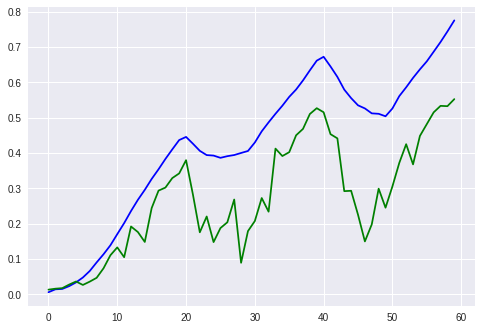

In [0]:
# Plot of accuracy and validation accuracy
import matplotlib.pyplot as plt
acc = history1.history['acc']
val_acc = history1.history['val_acc']

plt.plot(range(len(acc)), acc, color="blue")
plt.plot(range(len(val_acc)), val_acc, color="green")
plt.show()

## Conclusion

In 60 epochs, the model obtained a maximum validation accuracy of **55.28%**. The training accuracy however, is much higher than the validation accuracy - **77.56%**. This shows that there is significant overfitting. This can be addressed by:
1. Increasing the L2 regularization on the layer weights.
2. Using more aggressive image augmentation.
3. Performing negative hard mining to increase the weightage of classes the neural network is having difficulties predicting.